In [70]:
#차트기반 투자전략

In [71]:
#경고문구 제거
import warnings
warnings.filterwarnings("ignore")

#그래프 설정
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'AppleGothic'
rcParams['font.size'] = 15 # 20은 큰 것 같아서 15로 변경
rcParams['axes.unicode_minus'] = False 
import os
os.chdir("/Users/yang-eun-yeol/Desktop/my_quant/데이터")

In [72]:
#데이터 준비

import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("주가데이터"):
    sp_data = pd.read_csv("주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

In [73]:
for stock_name in sp_data_dict.keys():
    # 이동 평균 계산
    sp_data = sp_data_dict[stock_name]
    sp_data['MA_5'] = sp_data['Close'].rolling(5).mean()
    sp_data['MA_20'] = sp_data['Close'].rolling(20).mean()
    sp_data['MA_60'] = sp_data['Close'].rolling(60).mean()
    sp_data['MA_120'] = sp_data['Close'].rolling(120).mean()
    sp_data.dropna(inplace = True)

In [74]:
# 골든 / 데드크로스 추가
import itertools
import numpy as np

for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    for cross, st, lt in itertools.product(['G', 'D'], [5, 20], [60, 120]):
        output_col = "{}_{}_{}".format(cross, st, lt)
        st_col = "MA_" + str(st)
        lt_col = "MA_" + str(lt)
        st_data = sp_data[st_col].values
        lt_data = sp_data[lt_col].values
        if cross == "G":
            output = (st_data[1:] >= lt_data[1:]) & (st_data[:-1] < lt_data[:-1])
        elif cross == "D":
            output = (st_data[1:] < lt_data[1:]) & (st_data[:-1] >= lt_data[:-1])
        output = np.insert(output, 0, False)
        sp_data[output_col] = output   

In [75]:
#매매전략 구현

def calc_ror_using_gd_cross(sp_data_dict, stock_name, st, lt):
    money = 10 ** 8
    sp_data = sp_data_dict[stock_name]
    gc_idx_list = sp_data.loc[sp_data['G_{}_{}'.format(st, lt)]].index
    dc_idx_list = sp_data.loc[sp_data['D_{}_{}'.format(st, lt)]].index

    for buy_idx in gc_idx_list:
        if sum(dc_idx_list > buy_idx) == 0:
            sell_idx = sp_data.index.max()
        else:
            sell_idx = dc_idx_list[dc_idx_list > buy_idx].min()
        buy_price = sp_data.loc[buy_idx, 'Close']
        sell_price = sp_data.loc[sell_idx, 'Close']
        num_stocks = money / buy_price
        money = num_stocks * sell_price
    ror = (money - 10 ** 8) / 10 ** 8 * 100
    return round(ror, 3)
def calc_ror_using_buy_and_hold(sp_data_dict, stock_name):
    sp_data = sp_data_dict[stock_name]
    buy_price = sp_data["Close"].iloc[0]
    sell_price = sp_data["Close"].iloc[-1]
    ror = (sell_price - buy_price) / buy_price * 100
    return ror

In [77]:
#매매전략 검증 (시장 고려 x)

result = []
for stock_name in sp_data_dict.keys():
    record = [stock_name]
    for st, lt in itertools.product([5, 20], [60, 120]):
        profit = calc_ror_using_gd_cross(sp_data_dict, stock_name, st, lt)
        record.append(profit)
    ror = calc_ror_using_buy_and_hold(sp_data_dict, stock_name)    
    record.append(ror)
    result.append(record)

result = pd.DataFrame(result,
         columns = ["종목명", "5-60", "5-120", "20-60", "20-120", "바이앤홀드"])
display(result.describe().round(2))
result.set_index('종목명').idxmax(axis = 1).value_counts(normalize = True)

,5-60,5-120,20-60,20-120,바이앤홀드
count,2178.00,2178.00,2178.00,2178.00,2178.00
mean,63.34,45.30,54.71,48.95,138.30
std,230.87,191.47,209.03,183.23,322.50
min,-98.21,-96.65,-97.16,-97.07,-99.90
25%,-37.27,-40.66,-36.97,-39.20,-21.46
50%,4.06,-2.61,0.08,-0.45,42.25
75%,79.67,63.52,72.01,66.24,176.38
max,3944.32,3404.22,4030.00,2082.34,5036.36


바이앤홀드     0.488522
5-60      0.155647
20-60     0.135445
20-120    0.121671
5-120     0.098714
Name: proportion, dtype: float64

,종목명,시장구분,그룹
0,3S,KOSDAQ,10
6,BGF,KOSPI,15
9,BYC,KOSPI,11
11,CBI,KOSDAQ,9
12,CJ,KOSPI,18


시장구분
KOSDAQ    27.823635
KOSPI     27.681968
dtype: float64

<Axes: xlabel='그룹'>

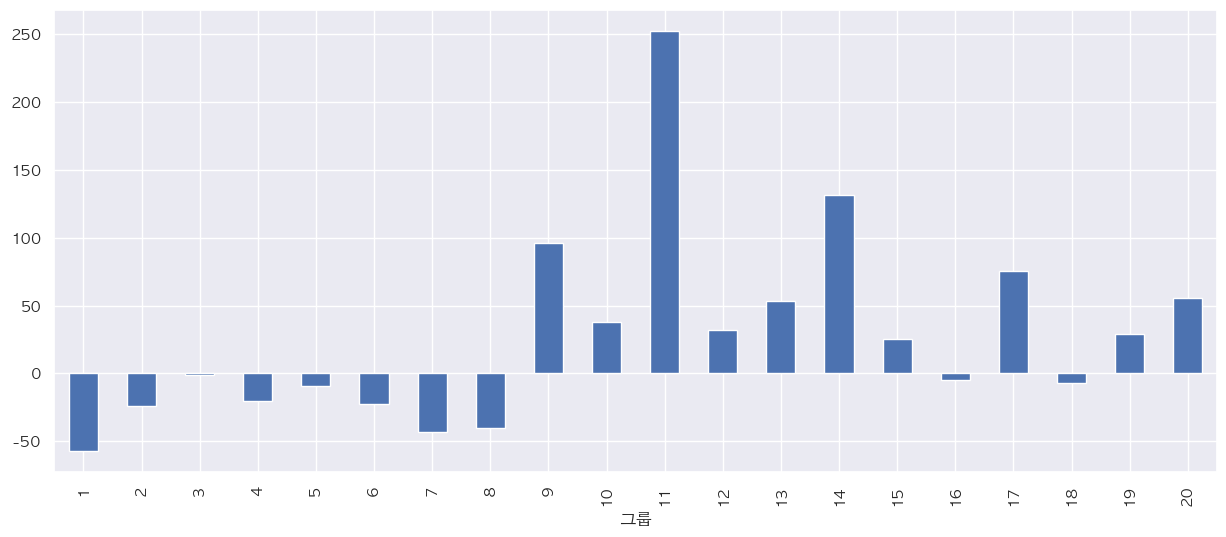

In [82]:
#매매전략 검증(시장고려o)

market_cap = pd.read_excel("211104_시가총액.xlsx")
market_cap = market_cap.loc[market_cap['종목명'].isin(result['종목명'])]
market_cap['그룹'] = pd.qcut(market_cap['시가총액'], 20, labels = range(1, 21))
market_cap['그룹'] = market_cap['그룹'].astype(int)
market_cap = market_cap[['종목명', '시장구분', '그룹']]
display(market_cap.head())
result = pd.merge(result, market_cap, on = "종목명")
cols = ['5-60', '5-120', '20-60', '20-120', '바이앤홀드']
display(result.groupby('시장구분')[cols].apply(np.mean))
result.groupby('그룹')[cols].apply(np.mean).plot(kind = 'bar', figsize = (15, 6))

In [83]:
#거래량 컬럼 +
for stock_name in sp_data_dict.keys():
    stock_data = sp_data_dict[stock_name]
    stock_data['V5'] = stock_data['Volume'].rolling(5).mean()
    stock_data.dropna(inplace = True)
    V5_10 = np.quantile(stock_data['V5'], 0.9)
    V5_20 = np.quantile(stock_data['V5'], 0.8)
    stock_data['V5_10_group'] = stock_data['V5'] > V5_10
    stock_data['V5_20_group'] = stock_data['V5'] > V5_20

In [90]:
#전략

def calc_ror(stock_data, buy_idx, num_day):
    sell_idx = buy_idx + num_day
    if sell_idx in stock_data.index:
        buy_price = stock_data['Close'].loc[buy_idx]
        sell_price = stock_data['Close'].loc[sell_idx]
        ror = (sell_price - buy_price) / buy_price * 100
        return ror
    else:
        return np.nan
S = pd.Series([1,2,3,4], index = ["A", "B", "C", "D"])
print((S % 2 == 0).index)


Index(['A', 'B', 'C', 'D'], dtype='object')


In [91]:
result_dict = dict()
for num_day in [60, 120, 240]:
    gc_result = []  # 골든 크로스
    v10_gc_result = []  # 거래량 상위 10% 골든 크로스
    v20_gc_result = []  # 거래량 상위 20% 골든 크로스
    random_result = []  # 임의

    for stock_name in sp_data_dict.keys():
        stock_data = sp_data_dict[stock_name]
        # 인덱스 정의
        gc_idx_list = stock_data.loc[stock_data["G_5_60"]].index
        v10_idx_list = stock_data.loc[stock_data["V5_10_group"]].index
        v10_gc_idx_list = v10_idx_list.intersection(gc_idx_list)
        v20_idx_list = stock_data.loc[stock_data["V5_20_group"]].index
        v20_gc_idx_list = v20_idx_list.intersection(gc_idx_list)
        ran_idx_candidate = stock_data.index[:-num_day]
        ran_idx_list = np.random.choice(
            ran_idx_candidate, min(len(ran_idx_candidate), 50), replace=False
        )

        for gc_idx in gc_idx_list:
            ror = calc_ror(stock_data, gc_idx, num_day)
            gc_result.append(ror)
        for v10_gc_idx in v10_gc_idx_list:
            ror = calc_ror(stock_data, v10_gc_idx, num_day)
            v10_gc_result.append(ror)
        for v20_gc_idx in v20_gc_idx_list:
            ror = calc_ror(stock_data, v20_gc_idx, num_day)
            v20_gc_result.append(ror)
        for random_idx in ran_idx_list:
            ror = calc_ror(stock_data, random_idx, num_day)
            random_result.append(ror)
    result_dict[num_day] = [gc_result, v10_gc_result, v20_gc_result, random_result]


In [92]:
#60일의 결과

gc_result, v10_gc_result, v20_gc_result, random_result = result_dict[60]  
gc_result = pd.Series(gc_result).describe()
v10_gc_result = pd.Series(v10_gc_result).describe()
v20_gc_result = pd.Series(v20_gc_result).describe()
random_result = pd.Series(random_result).describe()
total_result = pd.concat(
    [gc_result, v10_gc_result, v20_gc_result, random_result], axis=1
)
total_result.columns = ["골든크로스", "10%_골든크로스", "20%_골든크로스", "임의"]
display(total_result)

,골든크로스,10%_골든크로스,20%_골든크로스,임의
count,69898.000000,8733.000000,17025.000000,108900.000000
mean,4.343206,0.897543,2.211130,4.668062
std,30.564906,33.496585,34.039434,31.101289
min,-89.246159,-86.853147,-86.853147,-93.387391
25%,-11.224467,-16.671765,-15.377358,-10.868575
50%,-0.333056,-4.318937,-3.275530,0.000000
75%,12.940281,10.468750,11.764706,13.023430
max,1053.284672,1053.284672,1053.284672,1420.618557


In [93]:
#120일의 결과

gc_result, v10_gc_result, v20_gc_result, random_result = result_dict[120]  
gc_result = pd.Series(gc_result).describe()
v10_gc_result = pd.Series(v10_gc_result).describe()
v20_gc_result = pd.Series(v20_gc_result).describe()
random_result = pd.Series(random_result).describe()
total_result = pd.concat(
    [gc_result, v10_gc_result, v20_gc_result, random_result], axis=1
)
total_result.columns = ["골든크로스", "10%_골든크로스", "20%_골든크로스", "임의"]
display(total_result)

,골든크로스,10%_골든크로스,20%_골든크로스,임의
count,68041.000000,8293.000000,16253.000000,108900.000000
mean,8.177602,2.660970,4.662696,9.587103
std,45.556751,45.757685,47.823677,47.139126
min,-93.387391,-88.623853,-88.623853,-95.048662
25%,-14.882943,-20.949510,-19.858156,-14.129542
50%,-0.576923,-5.660377,-4.377104,0.413780
75%,18.823529,14.617940,16.519174,19.961333
max,1203.964758,1114.240305,1114.240305,1147.089947


In [94]:
#240일의 결고

gc_result, v10_gc_result, v20_gc_result, random_result = result_dict[240]  
gc_result = pd.Series(gc_result).describe()
v10_gc_result = pd.Series(v10_gc_result).describe()
v20_gc_result = pd.Series(v20_gc_result).describe()
random_result = pd.Series(random_result).describe()
total_result = pd.concat(
    [gc_result, v10_gc_result, v20_gc_result, random_result], axis=1
)
total_result.columns = ["골든크로스", "10%_골든크로스", "20%_골든크로스", "임의"]
display(total_result)

,골든크로스,10%_골든크로스,20%_골든크로스,임의
count,64010.000000,7233.000000,14424.000000,108023.000000
mean,15.991894,6.038554,8.332117,18.715037
std,71.662686,61.702953,65.492561,76.506248
min,-95.166667,-95.084332,-95.084332,-95.559611
25%,-19.594435,-27.481618,-26.344071,-18.724690
50%,0.113194,-7.297297,-5.932647,2.140673
75%,30.215422,21.935484,24.146898,33.093761
max,2519.863014,1068.421053,1204.347826,3099.268739


In [97]:
#데이터 세팅
import pandas as pd
stock_info = pd.read_excel("/Users/yang-eun-yeol/Desktop/my_quant/데이터/211104_시가총액.xlsx")
KOSPI_list = stock_info.loc[stock_info["시장구분"] == "KOSPI", "종목명"].tolist()
KOSDAQ_list = stock_info.loc[stock_info["시장구분"] == "KOSDAQ", "종목명"].tolist()
TOP100_list = stock_info.sort_values(by = "시가총액", ascending = False)['종목명'].iloc[:100].tolist()
import os
sp_data_dict = dict()
for file_name in os.listdir("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터"):
    stock_name = file_name.replace('.csv', '')
    sp_data = pd.read_csv("/Users/yang-eun-yeol/Desktop/my_quant/데이터/주가데이터/" + file_name, 
                           usecols = ["Date", "Close"], parse_dates = ['Date'])
    sp_data_dict[stock_name] = sp_data

In [98]:
#배열 / 컬럼 생성
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    sp_data["5일선"] = sp_data["Close"].rolling(5).mean()
    sp_data["20일선"] = sp_data["Close"].rolling(20).mean()
    sp_data["60일선"] = sp_data["Close"].rolling(60).mean()
    sp_data["120일선"] = sp_data["Close"].rolling(120).mean()
    sp_data.dropna(inplace = True)

    sp_data["정배열"] = (sp_data["5일선"] >= sp_data["20일선"])\
                          & (sp_data["20일선"] >= sp_data["60일선"])\
                          & (sp_data["60일선"] >= sp_data["120일선"])

    sp_data["역배열"] = (sp_data["5일선"] <= sp_data["20일선"])\
                          & (sp_data["20일선"] <= sp_data["60일선"])\
                          & (sp_data["60일선"] <= sp_data["120일선"])

In [99]:
#매매 전략

import numpy as np
def calc_ror_in_forward(sp_data):
    ror_list = []
    buy_point_list = sp_data["정배열"].values[1:] > sp_data["정배열"].values[:-1]
    buy_point_list = np.insert(buy_point_list, 0, False)
    buy_point_list = sp_data.index[buy_point_list]
    sell_point_list = sp_data["정배열"].values[:-1] > sp_data["정배열"].values[1:]
    sell_point_list = np.insert(sell_point_list, 0, False)
    sell_point_list = sp_data.index[sell_point_list]

    for buy_point in buy_point_list:
        if (sum(buy_point<sell_point_list) > 0) and (buy_point+1 <= sp_data.index[-1]):
            buy_price = sp_data.loc[buy_point + 1, "Close"]
            sell_point = sell_point_list[sell_point_list > buy_point][0] + 1
            if sell_point <= sp_data.index[-1]:
                sell_price = sp_data.loc[sell_point, "Close"]
                ror = (sell_price - buy_price) / buy_price * 100
                ror_list.append(ror)
        else:
            break
    return ror_list

In [100]:
#전체 종목

total_ror_list = []
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    ror_list = calc_ror_in_forward(sp_data)
    total_ror_list += ror_list
display(pd.Series(total_ror_list).describe().round(2))

count    57347.00
mean         1.00
std         18.74
min        -89.05
25%         -5.75
50%         -1.74
75%          2.25
max        701.56
dtype: float64

In [101]:
#매매 전략
def calc_ror_in_for_rev(sp_data):
    ror_list = []
    buy_point_list = sp_data["정배열"].values[1:] > sp_data["정배열"].values[:-1]
    buy_point_list = np.insert(buy_point_list, 0, False)
    buy_point_list = sp_data.index[buy_point_list]
    sell_point_list = sp_data["역배열"].values[1:] > sp_data["역배열"].values[:-1]
    sell_point_list = np.insert(sell_point_list, 0, False)
    sell_point_list = sp_data.index[sell_point_list]

    for buy_point in buy_point_list:
        if (sum(buy_point<sell_point_list) > 0) and (buy_point+1<=sp_data.index[-1]):
            buy_price = sp_data.loc[buy_point + 1, "Close"]
            sell_point = sell_point_list[sell_point_list > buy_point][0] + 1
            if sell_point <= sp_data.index[-1]:
                sell_price = sp_data.loc[sell_point, "Close"]
                ror = (sell_price - buy_price) / buy_price * 100
                ror_list.append(ror)
        else:
            break
    return ror_list

In [102]:
#전체 종목

total_ror_list = []
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    ror_list = calc_ror_in_for_rev(sp_data)
    total_ror_list += ror_list
display(pd.Series(total_ror_list).describe().round(2))

count    52251.00
mean         4.32
std         57.97
min        -95.39
25%        -17.61
50%         -8.34
75%          6.33
max       2537.21
dtype: float64

In [115]:
#캔들패턴

#기본 세팅
import os
os.chdir("/Users/yang-eun-yeol/Desktop/my_quant/데이터")

import pandas as pd
sp_data_dict = dict()
for file_name in os.listdir("주가데이터"):
    sp_data = pd.read_csv("주가데이터/" + file_name, parse_dates = ['Date'])
    stock_name = file_name.replace('.csv', '')
    sp_data_dict[stock_name] = sp_data

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'AppleGothic'
rcParams['axes.unicode_minus'] = False 

import warnings
warnings.filterwarnings("ignore")

In [108]:
#상승 장악(패턴탐지)
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cond_1 = (sp_data['Open'] > sp_data['Close']).values[:-1]
    cond_2 = (sp_data['Open'] < sp_data['Close']).values[1:]
    cond_3 = (sp_data['Low'].values[:-1] > sp_data['Open'].values[1:])
    cond_4 = (sp_data['High'].values[:-1] < sp_data['Close'].values[1:])

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, 0, False)
    sp_data["상승장악형"] = cond

In [110]:
#기대수익

def calc_ror_after_patt(sp_data, patt_col, n):
    patt_idx_list = sp_data.loc[sp_data[patt_col]].index
    no_patt_idx_list = sp_data.index.difference(patt_idx_list)
    max_idx = max(sp_data.index)
    
    patt_bidx_list = patt_idx_list[patt_idx_list + n < max_idx] + 1
    patt_sidx_list = patt_bidx_list + n
    no_patt_bidx_list = no_patt_idx_list[no_patt_idx_list + n < max_idx] + 1
    no_patt_sidx_list = no_patt_bidx_list + n
    # 패턴 발생 후 수익률 계산
    patt_bp_list = sp_data.loc[patt_bidx_list, 'Close'].values
    patt_sp_list = sp_data.loc[patt_sidx_list, 'Close'].values
    patt_ror_list = (patt_sp_list - patt_bp_list) / patt_bp_list * 100
    # 패턴 미 발생 후 수익률 계산
    no_patt_bp_list = sp_data.loc[no_patt_bidx_list, 'Close'].values
    no_patt_sp_list = sp_data.loc[no_patt_sidx_list, 'Close'].values
    no_patt_ror_list = (no_patt_sp_list - no_patt_bp_list) / no_patt_bp_list * 100
    
    return patt_ror_list.tolist(), no_patt_ror_list.tolist()

result_dict = dict()
for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "상승장악형", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

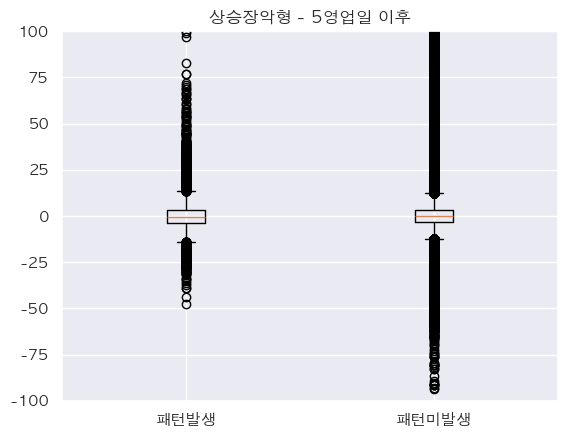

,패턴발생,패턴미발생
count,16418.00,4763307.00
mean,0.09,0.35
std,8.85,7.97
min,-47.84,-93.39
25%,-3.82,-3.20
50%,-0.44,0.00
75%,3.04,3.04
max,270.73,900.11


In [118]:
import matplotlib.pyplot as plt #폰트 설정
#5 영업일

plt.rcParams['font.family'] = 'AppleGothic'  
plt.title("상승장악형 - 5영업일 이후")
plt.boxplot(result_dict[5])
plt.xticks([1, 2], ["패턴발생", "패턴미발생"])
plt.ylim(-100, 100)
plt.show()

total_patt_ror_list, total_no_patt_ror_list = result_dict[5]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

In [120]:
#60 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[60]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,16102.00,4643833.00
mean,3.39,4.09
std,30.54,29.98
min,-80.65,-94.68
25%,-12.01,-11.08
50%,-0.99,-0.23
75%,12.23,12.64
max,1047.06,1531.84


In [121]:
#120 영업일
total_patt_ror_list, total_no_patt_ror_list = result_dict[120]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,15778.00,4513477.00
mean,6.55,8.14
std,43.12,45.58
min,-83.01,-97.33
25%,-16.17,-14.79
50%,-1.24,-0.12
75%,18.07,18.98
max,1066.49,2033.13


In [123]:
#하락 장악((패턴 탐지)

for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cond_1 = (sp_data['Open'] < sp_data['Close']).values[:-1]
    cond_2 = (sp_data['Open'] > sp_data['Close']).values[1:]
    cond_3 = (sp_data['High'].values[:-1] < sp_data['Open'].values[1:])
    cond_4 = (sp_data['Low'].values[:-1] > sp_data['Close'].values[1:])

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, 0, False)
    sp_data["하락장악형"] = cond

#기대수익 계산
result_dict = dict()
for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "하락장악형", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

In [124]:
#20영업일 

total_patt_ror_list, total_no_patt_ror_list = result_dict[20]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,20056.00,4726999.00
mean,1.15,1.40
std,16.40,16.62
min,-74.70,-93.39
25%,-6.98,-6.60
50%,-0.38,-0.22
75%,6.84,6.75
max,445.00,1226.67


In [125]:
#120 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[120]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,19405.00,4509850.00
mean,7.53,8.14
std,46.48,45.57
min,-93.29,-97.33
25%,-15.27,-14.79
50%,-0.74,-0.12
75%,18.49,18.97
max,1343.90,2033.13


In [128]:
#적삼병 

#패턴탐지
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cur_price = sp_data["Close"].values[2:]
    pre_price = sp_data["Close"].values[1:-1]
    sec_pre_price = sp_data["Close"].values[:-2]
    
    cond_1 = (cur_price > pre_price) & (pre_price > sec_pre_price)
    cond_2 = (sp_data['Open'] < sp_data['Close']).values[:-2]
    cond_3 = (sp_data['Open'] < sp_data['Close']).values[1:-1]
    cond_4 = (sp_data['Open'] < sp_data['Close']).values[2:]

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, [0, 0], False)
    sp_data["적삼병"] = cond

#기대 수익 계산
result_dict = dict()
for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "적삼병", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

In [129]:
#20 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[20]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,273910.00,4473145.00
mean,1.93,1.37
std,17.87,16.54
min,-86.93,-93.39
25%,-6.91,-6.58
50%,-0.26,-0.22
75%,7.58,6.70
max,1209.21,1226.67


In [130]:
#120 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[120]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,262033.00,4267222.00
mean,8.53,8.11
std,46.25,45.53
min,-97.33,-96.69
25%,-15.57,-14.75
50%,-0.41,-0.11
75%,20.31,18.89
max,1384.88,2033.13


In [134]:
#120 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[120]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
3display(result.round(2))

,패턴발생,패턴미발생
count,262033.00,4267222.00
mean,8.53,8.11
std,46.25,45.53
min,-97.33,-96.69
25%,-15.57,-14.75
50%,-0.41,-0.11
75%,20.31,18.89
max,1384.88,2033.13


In [137]:
#흑삼병 

#패턴탐지
for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cur_price = sp_data["Close"].values[2:]
    pre_price = sp_data["Close"].values[1:-1]
    sec_pre_price = sp_data["Close"].values[:-2]
    
    cond_1 = (cur_price < pre_price) & (pre_price < sec_pre_price)
    cond_2 = (sp_data['Open'] > sp_data['Close']).values[:-2]
    cond_3 = (sp_data['Open'] > sp_data['Close']).values[1:-1]
    cond_4 = (sp_data['Open'] > sp_data['Close']).values[2:]

    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, [0, 0], False)
    sp_data["흑삼병"] = cond

#기대수익 계산
result_dict = dict()
for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "흑삼병", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list



In [141]:
#20 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[20]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,394878.00,4352177.00
mean,1.25,1.42
std,17.00,16.59
min,-84.97,-93.39
25%,-6.98,-6.57
50%,-0.34,-0.21
75%,7.14,6.72
max,900.00,1226.67


In [140]:
#120 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[120]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,375236.00,4154019.00
mean,8.28,8.13
std,46.23,45.51
min,-95.12,-97.33
25%,-15.30,-14.75
50%,-0.38,-0.10
75%,19.82,18.90
max,1755.20,2033.13


In [142]:
#샛별형

#패턴 탐지

for stock_name in sp_data_dict.keys():
    sp_data = sp_data_dict[stock_name]
    cond_1 = sp_data["Close"].values[:-2] <= sp_data["Open"].values[:-2] * 1.1
    cond_2 = sp_data["Close"].values[1:-1] > sp_data["Open"].values[1:-1]
    cond_3 = sp_data["Close"].values[1:-1] < sp_data["Open"].values[1:-1] * 1.01
    cond_4 = sp_data["Close"].values[2:] >= sp_data["Open"].values[2:] * 1.1
    
    cond = cond_1 & cond_2 & cond_3 & cond_4
    cond = np.insert(cond, [0, 0], False)
    sp_data["샛별형"] = cond

result_dict = dict()
for n in [5, 20, 60, 120]:
    total_patt_ror_list = []
    total_no_patt_ror_list = []
    for stock_name in sp_data_dict.keys():
        sp_data = sp_data_dict[stock_name]
        patt_ror_list, no_patt_ror_list = calc_ror_after_patt(sp_data, "샛별형", n)
        total_patt_ror_list += patt_ror_list
        total_no_patt_ror_list += no_patt_ror_list
    result_dict[n] = total_patt_ror_list, total_no_patt_ror_list

In [144]:
#20 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[20]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,4667.00,4742388.00
mean,2.01,1.40
std,25.79,16.61
min,-73.74,-93.39
25%,-11.42,-6.60
50%,-2.34,-0.22
75%,8.50,6.75
max,412.98,1226.67


In [145]:
#120 영업일

total_patt_ror_list, total_no_patt_ror_list = result_dict[120]
result = pd.concat([pd.Series(total_patt_ror_list).describe(),
                   pd.Series(total_no_patt_ror_list).describe()],
                   axis = 1)
result.columns = ['패턴발생', '패턴미발생']
display(result.round(2))

,패턴발생,패턴미발생
count,4457.00,4524798.00
mean,9.60,8.14
std,64.88,45.55
min,-94.26,-97.33
25%,-22.13,-14.79
50%,-4.03,-0.12
75%,19.82,18.97
max,967.97,2033.13
